In [11]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
#Load the relevant modules and set up environment

from __future__ import division, print_function
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_style()
import dixoncoles as d 
import pandas as pd 
import numpy as np
%matplotlib inline

data,teams = d.load_and_preprocess();

# Extending Dixon & Coles

In this notebook, I will explore a simple extension to the Dixon & Coles model. In 1997, when the original paper was written, data on football matches was considerably more difficult to obtain. Consequently, the model produced by Dixon & Coles utilises only the most basic facts about a football match: the number of goals scored by either team. Today, however, a huge range of facts and statistics about each match are openly available. Here, I will describe how to extend the Dixon & Coles model to include the number of shots on target as well as the number of goals scored by each team.

In [2]:
data.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomeST,AwayST,BookiesHomeWin,BookiesDraw,BookiesAwayWin,Gameweek
Date,,,,,,,,,,
2015-08-08,0,10,0,1,2,3,0.500000,0.277778,0.250000,1
2015-08-08,1,13,2,2,3,10,0.735294,0.200000,0.090909,1
2015-08-08,2,15,2,2,5,5,0.588235,0.256410,0.181818,1
2015-08-08,3,12,4,2,8,5,0.512821,0.285714,0.230947,1
2015-08-08,4,14,1,0,1,4,0.606061,0.250000,0.166667,1


The data table I've constructed is very similar to the previous notebook. We are still looking at the Premier League (PL) season 2015/16, but there are now two extra columns: 'HomeST' and 'AwayST'. These quantify the number of goals scored by the home team and the away team, respectively. Let's look at how these are distributed.

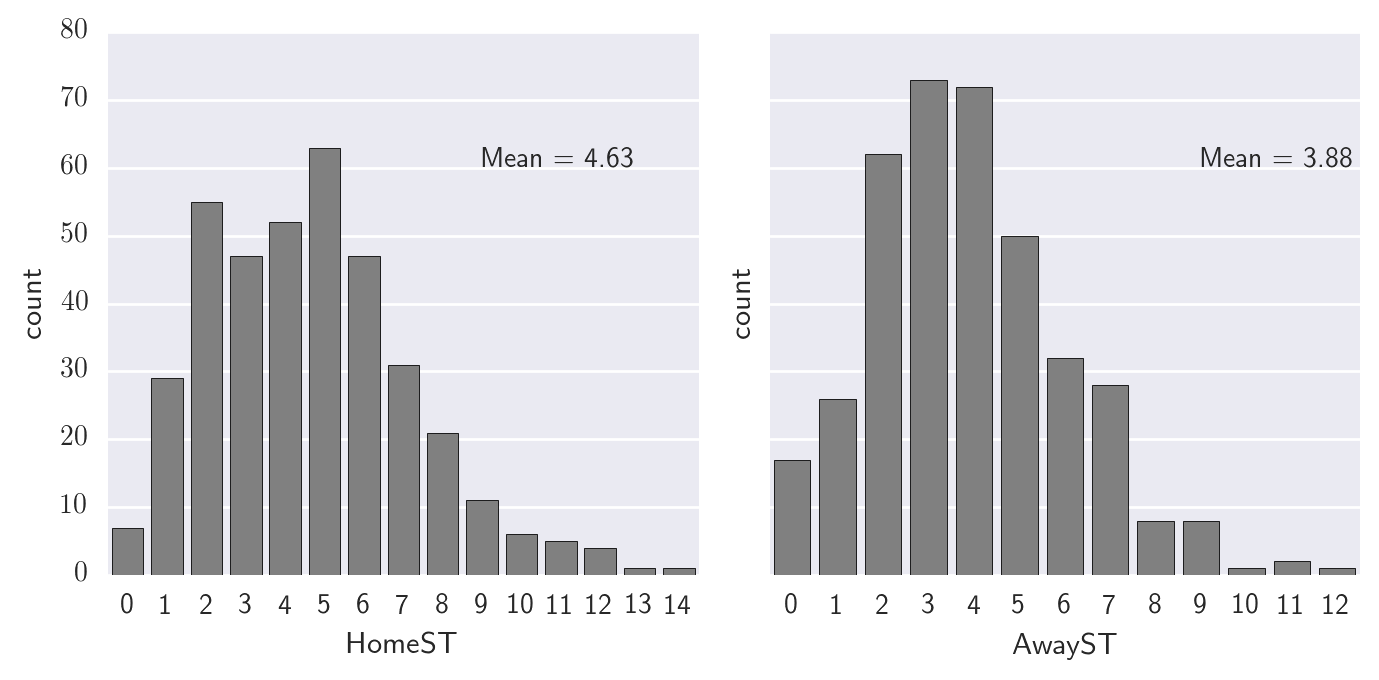

In [6]:
fig,ax = plt.subplots(1,2,figsize=(7,3.5),sharey=True)
sns.countplot(data['HomeST'],ax=ax[0],color='0.5')
sns.countplot(data['AwayST'],ax=ax[1],color='0.5')
ax[0].text(9,60,"Mean = {0:.2f}".format(data['HomeST'].mean()))
ax[1].text(9,60,"Mean = {0:.2f}".format(data['AwayST'].mean()));

The first important thing to note about these figures is that shots on target are a lot more common than goals. Obviously there must be at least as many shots on target as there are goals, but the mean number of shots on target is roughly three times as large as the number of goals scored. It is very rare that either team fails to achieve a single shot on target, whereas we saw previously that the away team are quite likely not to score any goals.

Ultimately, the new model should still produce probabilties for the outcomes of football matches. So, how should we incorporate the new data? My simple approach is to model the distribution of shots on target for either team as independent Poisson distributions, with rates parameterised in an identical way to the Dixon & Coles model:

`Q ~ Poisson(alpha_home * beta_away * gamma)`

`R ~ Poisson(alpha_away * beta_home)`,

where `Q` is the number of shots on target achieved by the home team, and `R` is the number achieved by the away team.
Then, I model the probability of either side scoring a goal as a binomial distribution, so that 

`X | Q ~ Binomial(epsilon_home)`

`Y | R ~ Binomial(epsilon_away)`.

In other words, the probability of the home team scoring `X` goals given that they achieved `Q` shots on target is a binomial distribution with a success probability of `epsilon_home`, and likewise for the away team. Thus, the new model contains 61 parameters: 20 `alpha` parameters, which quantify the propensity of each team to create chances, 20 `beta` parameters, which quantify how well a team defends, 20 `epsilon` parameters, which quantify how efficient teams are at converting shots on target into goals, and one `gamma` parameter that represents home advantage (we can see that home teams typically achieve roughly one more shot than the away team).

First, I'll fit the model to the PL season using the sliding window model from the previous notebook. Inspection of the parameters will give some intuition on the parameters.

In [3]:
alpha,beta,epsilon,gamma = d.fit_model_season(data,model='shots',window=20)
alpha = pd.DataFrame(alpha).rename(columns=lambda x: teams[x])
beta = pd.DataFrame(beta).rename(columns=lambda x: teams[x])
epsilon = pd.DataFrame(epsilon).rename(columns=lambda x: teams[x]);

First, let's look at the attacking parameters, `alpha`. I imposed the constraint that `sum(alpha) = n_teams`, i.e. the sum of all of the `alpha` parameters is equal to the number of teams in the league. This is to remove degeneracy in the likelihood. In order to convert the numbers into something more meaningful, I will multiply each `alpha` by the mean value of `beta`, so that the resulting number corresponds to a typical number of shots on target for each team.

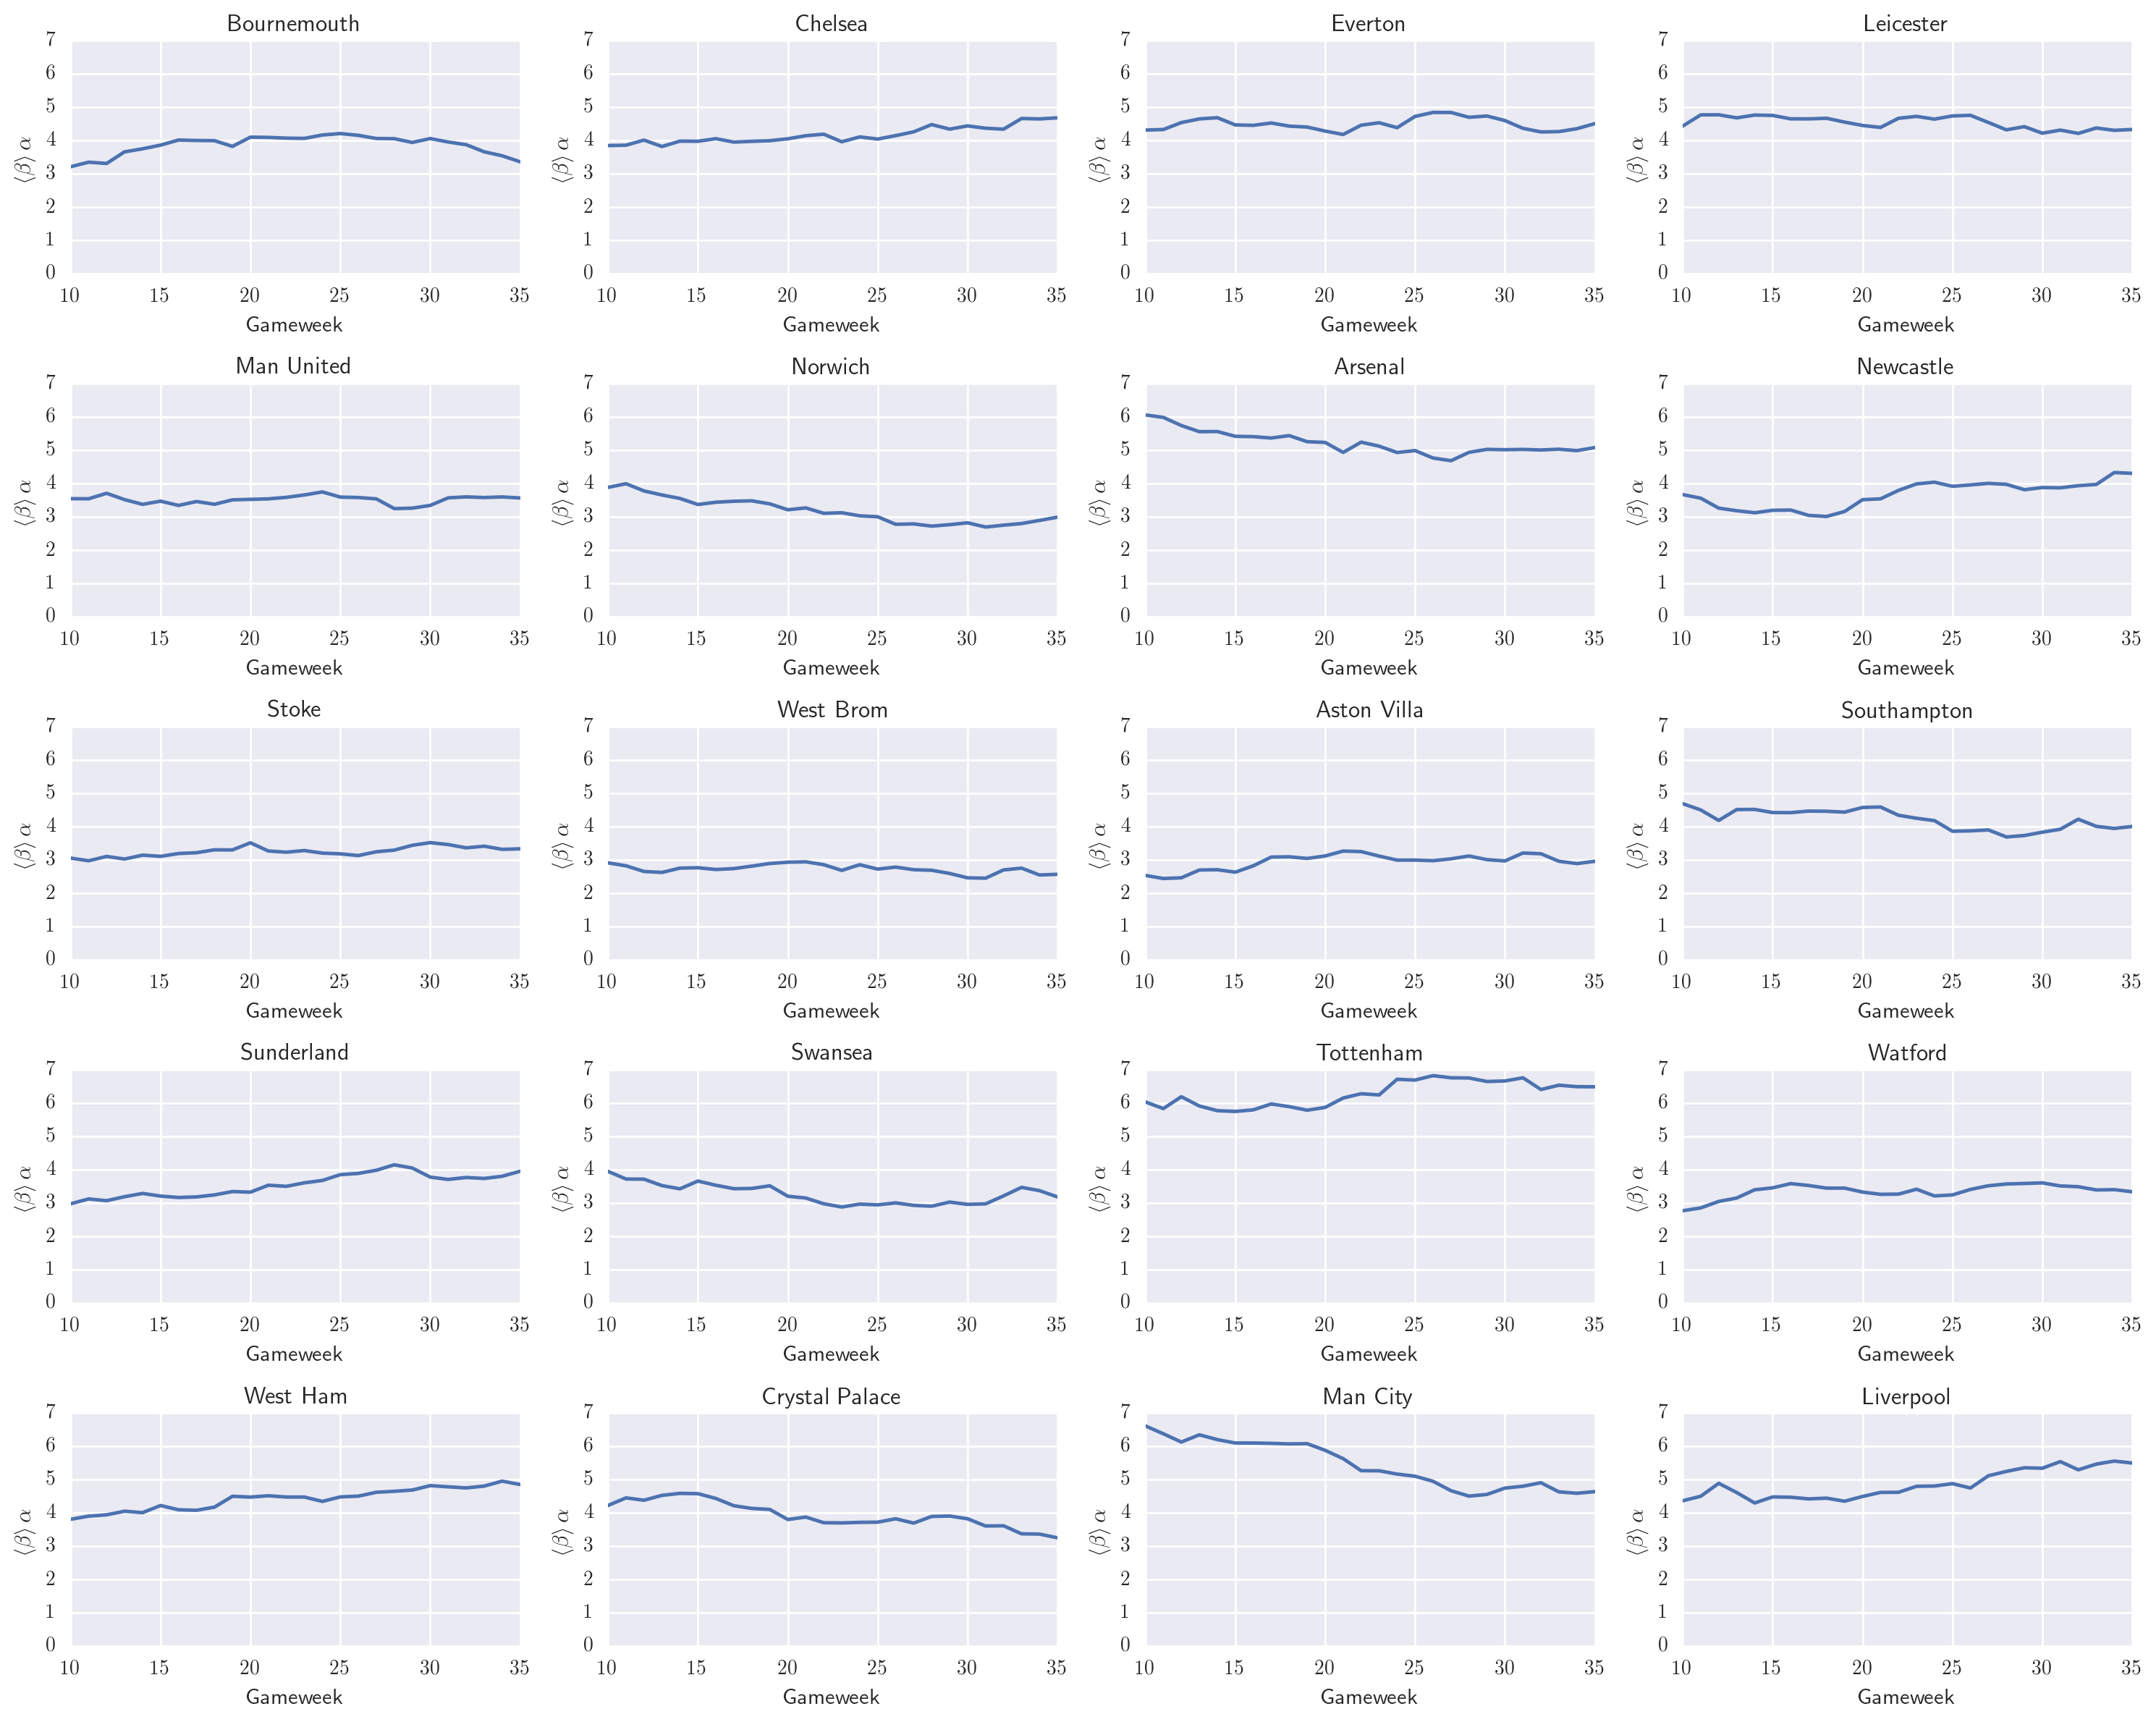

In [5]:
mean_beta = np.mean(beta.as_matrix())
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(mean_beta*alpha[team][10:])
    np.ravel(ax)[i].set_ylim((0.,7))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\langle \\beta \\rangle \\, \\alpha$");

There is a good deal of variation in the number of shots on target produced by the teams. Tottenham consistently produce between 6 and 7 shots on target per game, which is the highest in the league. Man City are also very effective at making chances. By contrast, Villa could only muster roughly three shots on target per game. Now let's look at how many shots on target each team typically concedes, which is quantified by the `beta` parameters:

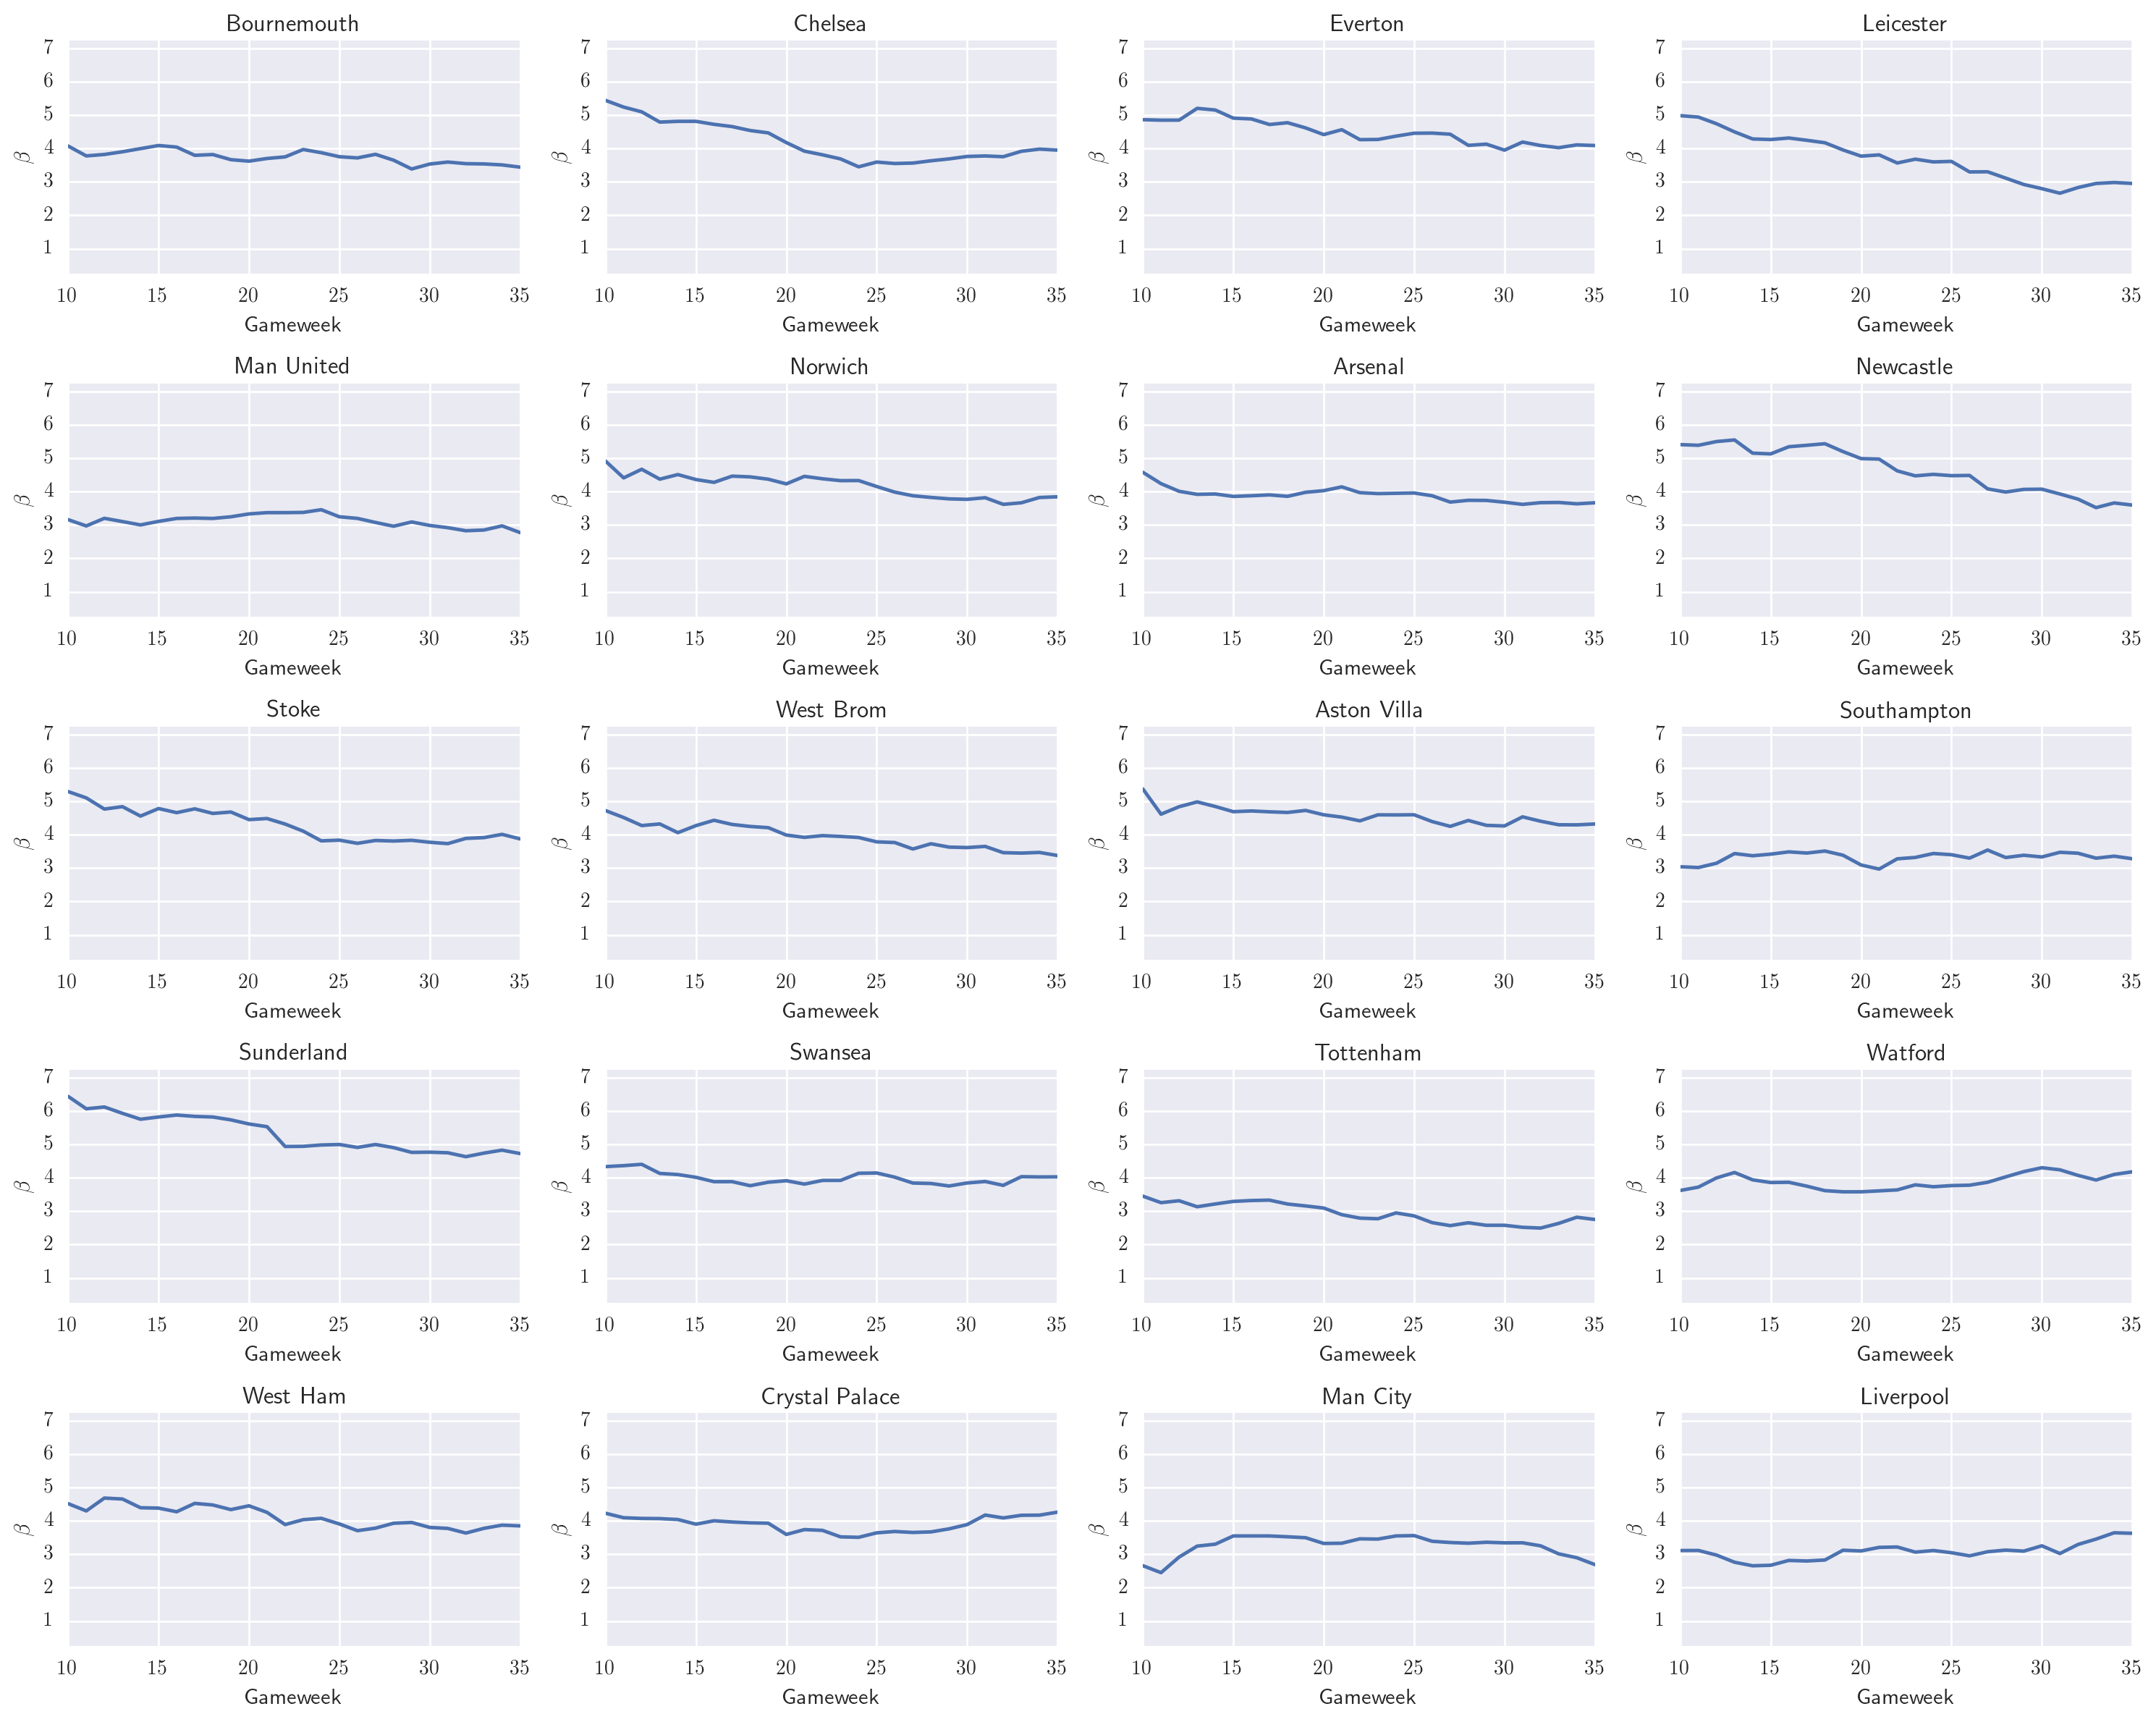

In [9]:
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(beta[team][10:])
    np.ravel(ax)[i].set_ylim((0.,7.))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\beta$");

Again, the results mostly reflect our intuition. Villa concede between 4 and 5 shots on target per game against an 'average' club (one with alpha = 1), whereas Tottenham only concede between 3 and 4. Surprisingly, Leicester seemed to concede a fair number of shots on target early on in the season, though their defense improved with time. Perhaps this is testament to the quality of their goalkeeper, Kasper Schmeichel. Finally, let's look at the efficiency parameters `epsilon`, which quantify the fraction of shots on target that each team typically converts into goals.

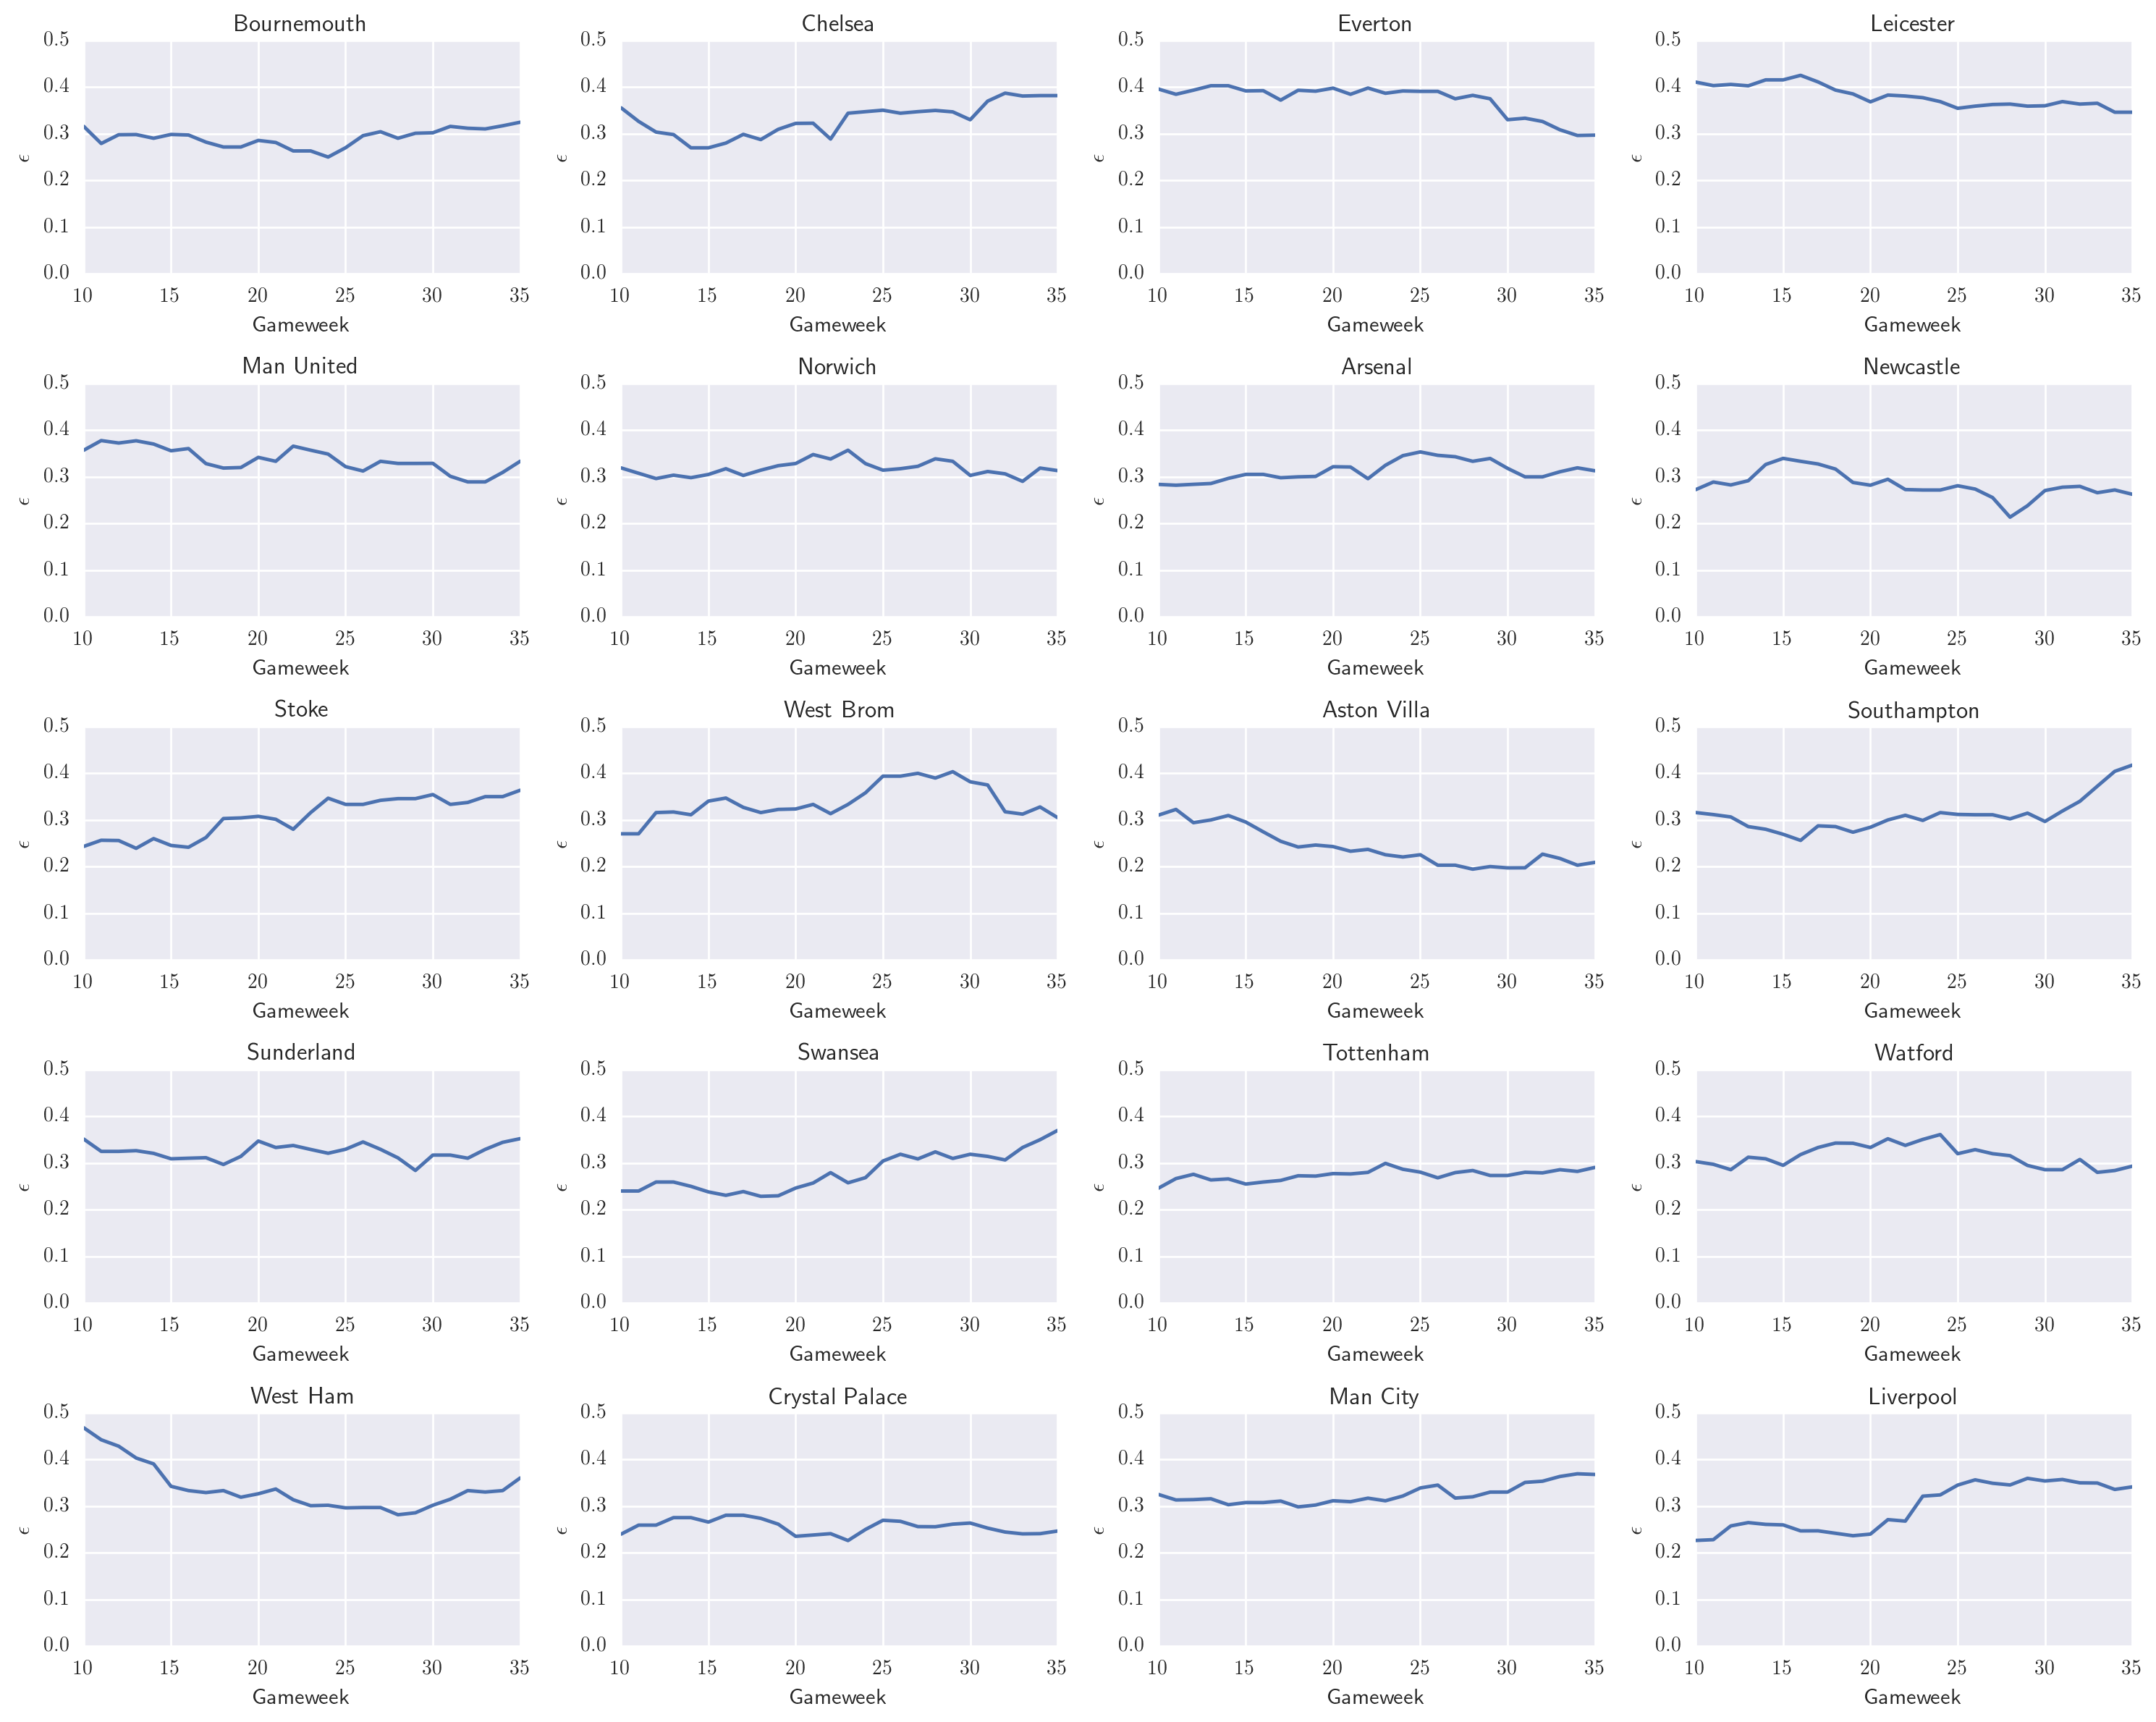

In [19]:
fig,ax = plt.subplots(5,4,figsize=(15,12))
for i,team in enumerate(teams):
    np.ravel(ax)[i].plot(epsilon[team][10:])
    np.ravel(ax)[i].set_ylim((0.,.5))
    np.ravel(ax)[i].set_title(team)
    np.ravel(ax)[i].set_xlabel("Gameweek")
    np.ravel(ax)[i].set_ylabel("$\\epsilon$");

All of the efficiency parameters are less than 0.5, and sit at around 0.3. This is a good sanity check of the model: the mean number of goals per game is 2.7, and the mean number of shots on target is 8.5, roughly three times as large. The between-team variation is interesting. Even though Tottenham create the most chances, they are not the most efficient team in converting these into goals. Leicester and Everton are the most reliable at converting their chances into goals. Even though Leicester typically produced one or two fewer chances per game than Tottenham, they were more ruthless in converting them into goals. It is also interesting to look at these numbers for Arsenal - they produce between 5 and 6 shots on target per game, but their conversion to goals is also inferior to that of Leicester. As an Arsenal fan, this makes sense: they engineer a lot of chances but frustratingly often fail to make these count! 

## Comparison with Dixon & Coles

I will now compare how predictive the new model is compared to the original Dixon & Coles approach. To do this, I will produce outcome probabilities for each match in the season. I'll use the pseudo-likelihood, described in Dixon & Coles and in the previous notebook, to fit the model. The pseudo-likelihood downweights matches in the past by a factor of `exp(-zeta * T)`, where T is the time since the match in question and the date when predictions are required. the parameter `zeta` quantifies how much matches in the past should be down-weighted. It turns out that the optimal value of `zeta` for the new model is nearly identical to the value in the previous notebook: `zeta = 0.003 days^-1`.

In [13]:
data_shots = d.calculate_odds(data,zeta=0.003,model='shots').dropna()
data_basic = d.calculate_odds(data,zeta=0.003,model='basic').dropna()

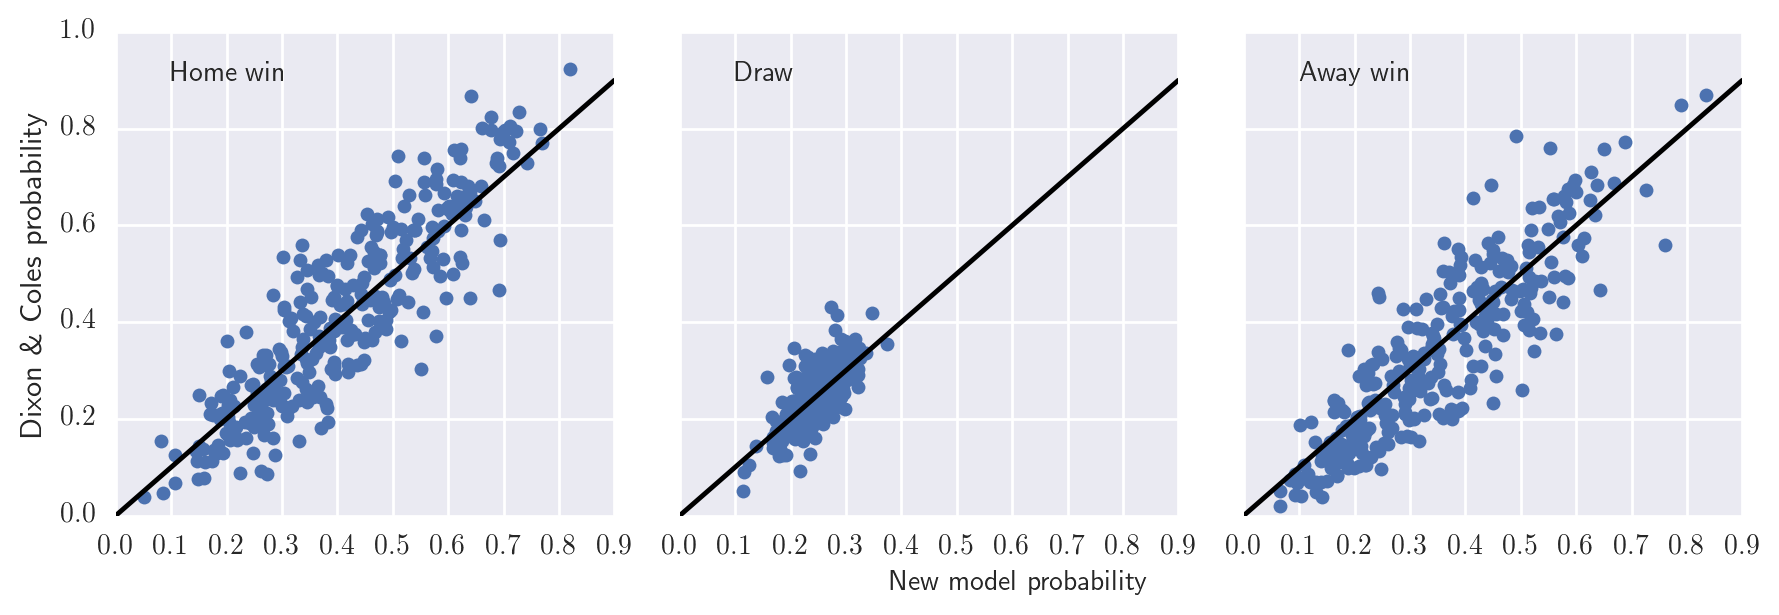

In [23]:
fig,ax = plt.subplots(1,3,figsize=(9,3),sharey=True,sharex=True)
x = np.linspace(0.,0.9)
ax[0].plot(data_shots['ProbHomeWin'],data_basic['ProbHomeWin'],'o',ms=5)
ax[1].plot(data_shots['ProbDraw'],data_basic['ProbDraw'],'o',ms=5)
ax[2].plot(data_shots['ProbAwayWin'],data_basic['ProbAwayWin'],'o',ms=5)
for axi in ax:
    axi.plot(x,x,c='k')
ax[0].set_ylabel("Dixon \\& Coles probability")
fig.text(0.5,0.,"New model probability")
ax[0].text(0.1,0.9,"Home win")
ax[1].text(0.1,0.9,"Draw")
ax[2].text(0.1,0.9,"Away win");

So, we can see that the two models produce different odds for each match. The odds are similar, which is evidenced by the fact that the points scatter around the black lines, which are `y = x`. There are definitely some systematic differences, however, so it is worth investigating if the new model is performing better than the basic Dixon & Coles approach. I'll do this by computing the predictive log-likelihood for each model. For a single match, the predictive log-likelihood is 

`pred_log_likelihood = log(prob_outcome)`

i.e., the log of the predicted probability of the true outcome. For example, the model might predict probabilities of (0.5, 0.2, 0.3) for home win, draw and away win for a given match. If the result turned out to be a draw, then the predictive log-likelihood is equal to log(0.2) =  -1.6. We then add up the contributions from all the matches in the season. If a model is good, then it will have a larger predictive log-likelihood, because it correctly assigns large probabilities to the correct outcome. Lets see how these numbers compare for our two models.

In [25]:
results = np.ones(len(data_shots)).astype(int)
x = data_shots['HomeGoals'].values
y = data_shots['AwayGoals'].values 
results[x>y] = 0
results[x==y] = 1 
results[x<y] = 2

pred_basic = d.result_likelihood(results,data_basic['ProbHomeWin'].values,data_basic['ProbDraw'].values\
                                 ,data_basic['ProbAwayWin'].values)

pred_shots = d.result_likelihood(results,data_shots['ProbHomeWin'].values,data_shots['ProbDraw'].values\
                                 ,data_shots['ProbAwayWin'].values)

print("The new model has a predictive log-likelihood of {0:.3f}".format(pred_shots))
print("The Dixon & Coles model has a predictive log-likelihood of {0:.3f}".format(pred_basic))

The new model has a predictive log-likelihood of -326.070
The Dixon & Coles model has a predictive log-likelihood of -327.226


The absolute values of these numbers are somewhat unimportant, but we can see that the new model has a larger predictive log-likelihood by about 1.2. This suggests that the new model is more effective at predicting the outcome of matches than the original Dixon & Coles model! A simple extension to include shots on target has produced better results. Let's check how well the Bookies are doing:

In [26]:
sum_bookies = (data_basic['BookiesHomeWin']+data_basic['BookiesDraw']+data_basic['BookiesAwayWin']).values
pred_bookies = d.result_likelihood(results,data_basic['BookiesHomeWin'].values/sum_bookies\
                                   ,data_basic['BookiesDraw'].values/sum_bookies
                                   ,data_basic['BookiesAwayWin'].values/sum_bookies)
print("The Bet365 model has a predictive log-likelihood of {0:.3f}".format(pred_bookies))

The Bet365 model has a predictive log-likelihood of -318.810


The improvement of 1.2 made by our new model pales in comparison to the Bet365 model, which has a difference in the predictive log-likelihood of 8.4. Their models will presumably use much more data, and much more sophisticated techniques. This shows how far predictive models of football matches have come since 1997, when the Dixon & Coles model was cutting edge!

## Simulating a Premier League Season